In [12]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib

sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)
from utils.bq_conn import bq_conn_file
# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report


#from pycaret.clustering import *
#from pycaret.classification import *
#from pycaret.regression import *

### Importo data

In [2]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset: 26553
El número de columnas del dataset: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [40]:
secopI_filter = secop_I.filter(items=['id_modalidad','estado_del_proceso','id_objeto_a_contratar','tipo_de_contrato',
                                      'departamento_ejecucion', 'numero_de_proceso','cuantia_proceso','id_grupo',
                                      'id_familia','id_clase','prorrogado','plazo_de_ejec_del_contrato_'
                                      ])
secopI_filter.head(5)

,id_modalidad,estado_del_proceso,id_objeto_a_contratar,tipo_de_contrato,departamento_ejecucion,numero_de_proceso,cuantia_proceso,id_grupo,id_familia,id_clase,prorrogado,plazo_de_ejec_del_contrato_
0,13,celebrado,50000000,suministro,cundinamarca,CPMMSFFAMCNo01DE2019,50000000,E,5022,502213,0,330
1,12,celebrado,53000000,prestacion de servicios,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,22980096902,E,5310,531027,1,660
2,12,celebrado,55000000,prestacion de servicios,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,35998452,E,5510,551015,1,31
3,12,liquidado,72000000,prestacion de servicios,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,16767536,F,7210,721015,0,170
4,19,celebrado,73000000,no encontrado en hoja proceso,bogota,CONVENIODEASOCIACIÓN231DE2018,0,F,7318,731810,0,360


### Clases a clasificar

In [41]:
secopI_filter['prorrogado'].value_counts()

0    25823
1      730
Name: prorrogado, dtype: Int64

### División train y test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
                                        secopI_filter.drop('prorrogado', axis = 1),
                                        secopI_filter['prorrogado'],
                                        train_size   = 0.9,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

### Preprocesamiento - Pipeline y ColumnTransformer


Las clases `ColumnTransformer` y `make_column_transformer` del módulo sklearn.compose permiten combinar múltiples transformaciones de preprocesado, especificando a qué columnas se aplica cada una. Como todo transformer, tiene un método de entrenamiento (fit) y otro de transformación (transform) . Esto permite que el aprendizaje de las transformaciones se haga únicamente con observaciones de entrenamiento, y se puedan aplicar después a cualquier conjunto de datos. La idea detrás de este módulo es la siguiente:

Definir todas las transformaciones (escalado, selección, filtrado...) que se desea aplicar y a qué columnas `ColumnTransformer()`. La selección de columnas puede hacerse por: nombre. índice, máscara booleana, slice, patrón regex, por tipo de columna o con las funciones de selección make_column_selector.

Aprender los parámetros necesarios para dichas transformaciones con las observaciones de entrenamiento `.fit()`.

Aplicar las transformaciones aprendidas a cualquier conjunto de datos `.transform()`.

In [43]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [44]:
encoded_cat = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

### Modelo

In [45]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

Profundidad del árbol: 5
Número de nodos terminales: 19


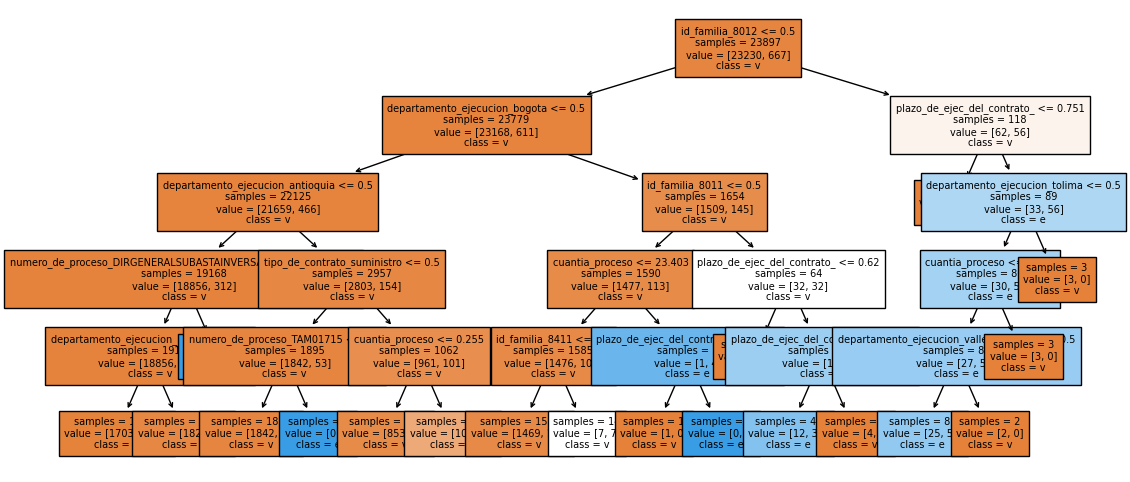

In [46]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = labels.tolist(),
            class_names   = 'ventas_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

### Podado del árbol (pruning)


Aunque inicialmente se ha empleado un valor de max_depth=5, este no tiene por qué ser el mejor valor. Con el objetivo de identificar la profundidad óptima que consigue reducir la varianza y aumentar la capacidad predictiva del modelo, se somete al árbol a un proceso de pruning.

In [47]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train_prep, y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

KeyboardInterrupt: 

In [9]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.0}

Una vez identificado el valor óptimo de `ccp_alpha`, se reentrena el árbol indicando este valor en sus argumentos. Si en el `GridSearchCV()` se indica `refit=True`, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.  

In [10]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol: 1
Número de nodos terminales: 2


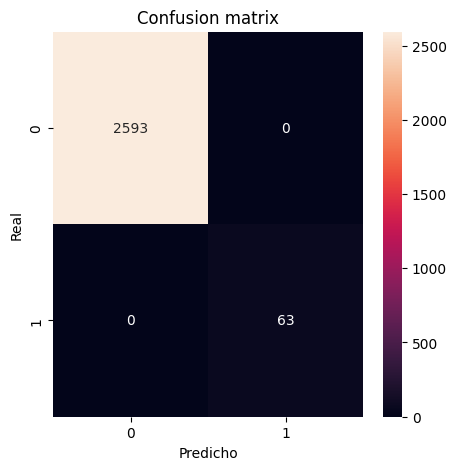

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2593
         1.0       1.00      1.00      1.00        63

    accuracy                           1.00      2656
   macro avg       1.00      1.00      1.00      2656
weighted avg       1.00      1.00      1.00      2656



In [15]:
# Error de test del modelo final
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test_prep)
# Calcula la matriz de confusión
#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()
    print (classification_report(y_test, pred_y))
mostrar_resultados(y_test, predicciones)

## Importancia de predictores


La importancia de cada predictor en modelo se calcula como la reducción total (normalizada) en el criterio de división, en este caso el índice Gini, que consigue el predictor en las divisiones en las que participa. Si un predictor no ha sido seleccionado en ninguna divisón, no se ha incluido en el modelo y por lo tanto su importancia es 0.

In [38]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': labels.tolist(),
                             'importancia': modelo_final.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,tiempo_adiciones_en_dias,1.0
0,id_modalidad,0.0
12699,numero_de_proceso_DIRGRALCONVENIODEINTEGRACION...,0.0
12706,numero_de_proceso_DIRGRALCONVENIODEINTEGRACION...,0.0
12705,numero_de_proceso_DIRGRALCONVENIODEINTEGRACION...,0.0
...,...,...
6351,numero_de_proceso_2410222017,0.0
6350,numero_de_proceso_2410212016,0.0
6349,numero_de_proceso_2410212015,0.0
6348,numero_de_proceso_2410202017,0.0
